# Исследование надёжности заёмщиков

## Введение

Данное исследование **построено на** статистике о платёжеспособности клиентов, предоставленной кредитным отделом банка, и **направлено на** изучение факторов, влияющих на факт погашения клиентом кредита в срок.

Иследование состоит из **следующих этапов**:

1. [Обзор данных и их предобработка](#step_1):
    * [Импорт библиотек](#step_1.1);
    * [Общая информация о данных](#step_1.2);
    * [Обработка пропусков и дубликатов, проверка данных](#step_1.3);
    * [Вывод](#step_1.4).
2. [Анализ данных](#step_2):
    * [Анализ категорий по цели получения кредита](#step_2.1);
    * [Вероятность получения кредита, исходя из уровня дохода](#step_2.2);
    * [Зависимость между наличием детей и возвратом кредита в срок](#step_2.3);
    * [Зависимость между семейным положением и возвратом кредита в срок](#step_2.4);
    * [Зависимость между уровнем дохода и возвратом кредита в срок](#step_2.5);
    * [Зависимость между целями кредита и возвратом кредита в срок](#step_2.6);
    * [Вывод](#step_2.7).
3. [Общий вывод](#step_3);
4. [Рекомендации](#step_4).

**Результатом исследования** являются рекомендации, на которые следует опираться банку при построении модели *кредитного скоринга* — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Этап 1. Обзор данных и их предобработка <a id='step_1'></a>

### Импорт библиотек <a id='step_1.1'></a>

In [1]:
import pandas as pd
import numpy as np
from IPython import display

from pymystem3 import Mystem
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

### Общая информация о данных <a id='step_1.2'></a>

In [2]:
# Прочитаем файл clients_info.csv с информацией о платёжеспособности клиентов банка и сохраним его в переменной clients_info
clients_info = pd.read_csv('C:/Users/Public/Jupyter/clients_info.csv')
clients_info.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [3]:
# Получим общую информацию о данных таблицы clients_info
display.display(data=clients_info.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Данные представлены в виде таблицы, включающей в себя 21 525 строк и 12 столбцов. При этом 5 столбцов с целочисланными данными (тип < int >), 2 столбца типа < float > и 5 столбцов типа < object >.

Разберём, какие в таблице столбцы, и какую информацию они содержат:
- [`children`](#children) — количество детей в семье;
- [`days_employed`](#days_empl) — общий трудовой стаж в днях;
- [`dob_years`](#years) — возраст клиента в годах;
- [`education`](#edu) — уровень образования клиента;
- [`education_id`](#edu_id) — идентификатор уровня образования;
- [`family_status`](#fam_stat) — семейное положение;
- [`family_status_id`](#fam_stat_id) — идентификатор семейного положения;
- [`gender`](#gender) — пол клиента;
- [`income_type`](#inc_type) — тип занятости;
- [`debt`](#debt) — имел ли задолженность по возврату кредитов;
- [`total_income`](#inc) — ежемесячный доход;
- [`purpose`](#purp) — цель получения кредита.

Отметим, что даже предварительный взгляд на датафрейм позволил увидеть, что данные в некоторых столбцах имеют отрицательное значение, что на практике невозможно. Далее мы обратим на это внимание при более подробном изучении каждого столбца.

Также есть некоторое несоответствие типа данных в ряде столбцов (например, столбец days_employed должен быть целочисленным). Кроме того, различное количество значений в столбцах указывает на возможное наличие в таблице пропусков.

### Обработка пропусков и дубликатов, проверка данных <a id='step_1.3'></a>

#### Обработка пропусков

Проверим данные на наличие пропусков.

In [4]:
clients_info.isnull().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Пустые значения свидетельствуют, что по некоторым клиентам доступна не вся информация. Это может быть связано с различными причинами: нежелание клиента предоставлять соответствующие данные, либо проблема с записью данных. Каждый из столбцов следует разобрать отдельно и выявить причину.

Поскольку пропуски наблюдаются в количественных переменных, их необходимо заполнить количественными переменными. Предполагается, что данные в выборке очень неоднородны, поэтому использование средней арифметической не подойдет - лучше всего использовать медианные значения. При этом медианное значение `total_income` может различаться в разных категориях дохода: доходы пенсионеров маловероятно равны доходам сотрудников и компаньонов. Столбец `days_employed` также, согласно взгляда на таблицу, как-то связан с типом занятости: мы видим, что у пенсионеров данные имеют положительное, но слишком высокое значение; а у остальных типов занятости - отрицательное значение. Также трудовой стаж можно попробовать восстановить, исходя из возраста клиента (в рамках первой выделенной категории). Соответственно, и обработка данных должна проходить в рамках данных категорий.

Оба столбца необходимо обрабатывать в рамках типа занятости. В связи с этим, найдем уникальные значения по столбцу `income_type`.

In [5]:
clients_info['income_type'].unique()

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

Получаем 8 категорий для заполнения пропусков. Изучим количество имеющихся данных и количество пропусков по каждой категории в столбцах с пропусками.

In [6]:
print('Заполненные данные для days_employed:')
print(clients_info.groupby('income_type')['days_employed'].count())
print()
print('Пропущенные данные для days_employed:')
print(clients_info['days_employed'].isnull().groupby(clients_info['income_type']).sum().astype('int'))
print()
print()
print('Заполненные данные для total_income:')
print(clients_info.groupby('income_type')['total_income'].count())
print()
print('Пропущенные данные для total_income:')
print(clients_info['total_income'].isnull().groupby(clients_info['income_type']).sum().astype('int'))

Заполненные данные для days_employed:
income_type
безработный            2
в декрете              1
госслужащий         1312
компаньон           4577
пенсионер           3443
предприниматель        1
сотрудник          10014
студент                1
Name: days_employed, dtype: int64

Пропущенные данные для days_employed:
income_type
безработный           0
в декрете             0
госслужащий         147
компаньон           508
пенсионер           413
предприниматель       1
сотрудник          1105
студент               0
Name: days_employed, dtype: int64


Заполненные данные для total_income:
income_type
безработный            2
в декрете              1
госслужащий         1312
компаньон           4577
пенсионер           3443
предприниматель        1
сотрудник          10014
студент                1
Name: total_income, dtype: int64

Пропущенные данные для total_income:
income_type
безработный           0
в декрете             0
госслужащий         147
компаньон           508
пенсионер

Отметим, что и для `total_income`, и для `days_employed` мы получили одинаковые результаты. Это может говорить о том, что пропуски в указанных столбцах допущены в одних и тех же строках.
Также вышеприведенные таблицы дают нам информацию о том, что пропуски в каждой категории составляют около 10% и более, а значит, мы не можем удалить строки ни в одной из категорий - иначе это повлечет за собой некорректные результаты анализа данных.

Отметим, что для безработных и пенсионеров значения `days_employed` положительны, но очень высоки. Если это данные по России, человек может работать с 16 лет (в особых случаях с 15 лет). А, значит, его стаж, например, в 31 год максимально равен 5475 дней. В таблице же значение для такого возраста свыше 900 лет. Данные для других категорий принимают отрицательные значения, которые в абсолютном выражении могут быть близки к реальным. Тем не менее, становится очевидным, что пропуски для эго столбца пока не могут быть заполнены. Но мы можем заполнить пропуски для столбца `total_income`. Чтобы это сделать, напишем функцию и изучим данные для разных категорий дохода.

In [7]:
# Функция для заполнения пропусков по величине дохода для категории
def total_income_fillna(income_type, filtered_data):
    condition = clients_info['income_type'] == income_type
    clients_info.loc[condition, 'total_income'] = (clients_info
                                                       .loc[condition, 'total_income']
                                                       .fillna(filtered_data['total_income'].median())
                                                  )

##### Безработные

In [8]:
unemployed_clients = clients_info[clients_info['income_type'] == 'безработный']
unemployed_clients.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.500000,366413.652744,38.000000,0.500000,0.500000,0.500000,131339.751676
std,0.707107,40855.478519,9.899495,0.707107,0.707107,0.707107,100950.466876
min,0.000000,337524.466835,31.000000,0.000000,0.000000,0.000000,59956.991984
25%,0.250000,351969.059790,34.500000,0.250000,0.250000,0.250000,95648.371830
50%,0.500000,366413.652744,38.000000,0.500000,0.500000,0.500000,131339.751676
75%,0.750000,380858.245699,41.500000,0.750000,0.750000,0.750000,167031.131522
max,1.000000,395302.838654,45.000000,1.000000,1.000000,1.000000,202722.511368


В этой категории всего 2 человека, данные по которым не имеют пропусков: значение для одного будет минимумом, а для другого - максимум. Среднее между ними также будет являться медианой. Хотя в данной категории и нет пропусков, но данные нуждаются в дальнейшей обработке, к которой мы вернемся позже.

##### В декрете

In [9]:
maternity_clients = clients_info[clients_info['income_type'] == 'в декрете']
maternity_clients.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000
mean,2.0,-3296.759962,39.0,1.0,0.0,1.0,53829.130729
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.0,-3296.759962,39.0,1.0,0.0,1.0,53829.130729
25%,2.0,-3296.759962,39.0,1.0,0.0,1.0,53829.130729
50%,2.0,-3296.759962,39.0,1.0,0.0,1.0,53829.130729
75%,2.0,-3296.759962,39.0,1.0,0.0,1.0,53829.130729
max,2.0,-3296.759962,39.0,1.0,0.0,1.0,53829.130729


В этой категории всего 1 человек, по которому есть данные: значение для него будет и минимумом, и максимумом, и медианой. Хотя в данной категории и нет пропусков, но данные нуждаются в обработке.

##### Госслужащие

In [10]:
civserv_clients = clients_info[clients_info['income_type'] == 'госслужащий']
civserv_clients.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,1459.000000,1312.000000,1459.000000,1459.000000,1459.000000,1459.000000,1312.000000
mean,0.622344,-3399.896902,40.636737,0.671693,0.857437,0.058944,170898.309923
std,1.113242,2788.371363,10.744491,0.577196,1.366448,0.235602,96878.763554
min,-1.000000,-15193.032201,0.000000,0.000000,0.000000,0.000000,29200.077193
25%,0.000000,-4759.399260,32.000000,0.000000,0.000000,0.000000,105294.668418
50%,0.000000,-2689.368353,40.000000,1.000000,0.000000,0.000000,150447.935283
75%,1.000000,-1257.171811,48.000000,1.000000,1.000000,0.000000,209173.052434
max,20.000000,-39.954170,75.000000,4.000000,4.000000,1.000000,910451.470814


В этой категории 1 459 человек, для 147 из них пропущены данные.

Отметим, что все данные трудового стажа в рамках данной категории принимают отрицательные значения, хотя разброс у них и велик. Мы пока не можем обработать пропуски по ним, так как медианное значение будет искажать данные. Для начала разберёмся с данными в столбце (см. [соответствующий пункт](#days_empl)), а затем заполним пропущенные значения.

В данных по ежемесячному доходу все значения положительны, соответственно, мы можем заменить пропуски на медианное значение.

In [11]:
total_income_fillna('госслужащий', civserv_clients)

##### Компаньоны

In [12]:
compan_clients = clients_info[clients_info['income_type'] == 'компаньон']
compan_clients.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,5085.000000,4577.000000,5085.000000,5085.000000,5085.000000,5085.000000,4.577000e+03
mean,0.598623,-2111.524398,39.697542,0.715438,1.032448,0.073943,2.024175e+05
std,1.483968,2048.448594,10.671115,0.591248,1.492681,0.261704,1.304811e+05
min,-1.000000,-17615.563266,0.000000,0.000000,0.000000,0.000000,2.870281e+04
25%,0.000000,-2876.648520,31.000000,0.000000,0.000000,0.000000,1.258877e+05
50%,0.000000,-1547.382223,39.000000,1.000000,0.000000,0.000000,1.723580e+05
75%,1.000000,-685.687432,48.000000,1.000000,1.000000,0.000000,2.439078e+05
max,20.000000,-30.195337,74.000000,3.000000,4.000000,1.000000,2.265604e+06


В этой категории 5 085 человек, для 508 из них пропущены данные.

Отметим, что все данные трудового стажа в рамках данной категории принимают отрицательные значения, хотя разброс у них и велик. Мы пока не можем обработать пропуски по ним, так как медианное значение будет искажать данные. Для начала разберёмся с данными в столбце (см. [соответствующий пункт](#days_empl)), а затем заполним пропущенные значения.

В данных по ежемесячному доходу все значения положительны, заменим пропуски на медианное значение.

In [13]:
total_income_fillna('компаньон', compan_clients)

##### Пенсионеры

In [14]:
retired_clients = clients_info[clients_info['income_type'] == 'пенсионер']
retired_clients.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,3856.000000,3443.000000,3856.000000,3856.000000,3856.000000,3856.000000,3443.000000
mean,0.132002,365003.491245,59.063019,0.913900,0.985737,0.056017,137127.465690
std,1.014271,21069.606065,7.618526,0.510185,1.315202,0.229984,80246.953231
min,-1.000000,328728.720605,0.000000,0.000000,0.000000,0.000000,20667.263793
25%,0.000000,346649.346146,56.000000,1.000000,0.000000,0.000000,82881.443465
50%,0.000000,365213.306266,60.000000,1.000000,0.000000,0.000000,118514.486412
75%,0.000000,383231.396871,64.000000,1.000000,2.000000,0.000000,169700.433010
max,20.000000,401755.400475,74.000000,4.000000,4.000000,1.000000,735103.270167


В этой категории 3 856 человек, для 413 из них пропущены данные.

Отметим, что все данные трудового стажа и ежемесячного дохода в рамках данной категории принимают положительные значения. Однако, значения в столбце с трудовым стажем имеют слишком большой разброс - с ним явно что-то не так. Чтобы заполнение пропусков не исказило ещё больше данные, вернёмся к этому столбцу позже. А пропуски в столбце с доходом мы можем обработать - заменим пропущенные значения на медианные.

In [15]:
total_income_fillna('пенсионер', retired_clients)

##### Предприниматели

In [16]:
enterpr_clients = clients_info[clients_info['income_type'] == 'предприниматель']
enterpr_clients.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,2.0,1.000000,2.00000,2.0,2.000000,2.0,1.000000
mean,0.0,-520.848083,42.50000,0.0,0.500000,0.0,499163.144947
std,0.0,NaN,21.92031,0.0,0.707107,0.0,NaN
min,0.0,-520.848083,27.00000,0.0,0.000000,0.0,499163.144947
25%,0.0,-520.848083,34.75000,0.0,0.250000,0.0,499163.144947
50%,0.0,-520.848083,42.50000,0.0,0.500000,0.0,499163.144947
75%,0.0,-520.848083,50.25000,0.0,0.750000,0.0,499163.144947
max,0.0,-520.848083,58.00000,0.0,1.000000,0.0,499163.144947


В этой категории всего 2 человека, и только по одному есть данные: значение для него будет и минимумом, и максимумом, и медианой.

Некорректно будет присваивать второму предпринимателю то же значение стажа и дохода, что и первому, поскольку их возраст различен; и у нас нет информации - в какой сфере они занимаются предпринимательской деятельностью (одинакова она или различается). И удаление строки видится более рациональным шагом, поскольку от всех данных это небольшой процент, а ввод некорректных данных в пропуск может значительно исказить анализ данной категории.

In [17]:
condition = clients_info.loc[(clients_info['income_type'] == 'предприниматель') & (clients_info['total_income'].isnull())]
clients_info.drop(condition.index, inplace=True)

##### Сотрудники

In [18]:
employee_clients = clients_info[clients_info['income_type'] == 'сотрудник']
employee_clients.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,11119.000000,10014.000000,11119.000000,11119.000000,11119.000000,11119.000000,1.001400e+04
mean,0.641784,-2326.499216,39.821027,0.849627,0.955661,0.095422,1.613803e+05
std,1.448530,2307.924129,10.655127,0.525186,1.427291,0.293810,9.132251e+04
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.136765e+04
25%,0.000000,-3108.123025,32.000000,1.000000,0.000000,0.000000,1.027956e+05
50%,0.000000,-1574.202821,39.000000,1.000000,0.000000,0.000000,1.425944e+05
75%,1.000000,-746.027361,48.000000,1.000000,1.000000,0.000000,1.968281e+05
max,20.000000,-24.141633,74.000000,4.000000,4.000000,1.000000,1.726276e+06


В этой категории 11 119 человек, для 1 105 из них пропущены данные.

Отметим, что все данные трудового стажа в рамках данной категории принимают отрицательные значения, хотя разброс у них и велик. Как и в предшествующих категориях, мы не можем пока заполнить для них пропуски. Вернёмся к этому позднее.

В данных по ежемесячному доходу все значения положительны, заменим пропуски на медианное значение.

In [19]:
total_income_fillna('сотрудник', employee_clients)

##### Студенты

In [20]:
students_clients = clients_info[clients_info['income_type'] == 'студент']
students_clients.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000
mean,0.0,-578.751554,22.0,0.0,4.0,0.0,98201.625314
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.0,-578.751554,22.0,0.0,4.0,0.0,98201.625314
25%,0.0,-578.751554,22.0,0.0,4.0,0.0,98201.625314
50%,0.0,-578.751554,22.0,0.0,4.0,0.0,98201.625314
75%,0.0,-578.751554,22.0,0.0,4.0,0.0,98201.625314
max,0.0,-578.751554,22.0,0.0,4.0,0.0,98201.625314


В этой категории всего 1 человек, по которому есть данные: значение для него будет и минимумом, и максимумом, и медианой. Хотя в данной категории и нет пропусков, но данные нуждаются в дальнейшей обработке, к которой мы вернемся позже.

Далее проверим, что у нас не осталось пропущенных значений в Датафрейме, кроме столбца `days_employed`, который мы заполним после работы с данными в нём.

In [21]:
clients_info.isnull().sum()

children               0
days_employed       2173
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income           0
purpose                0
dtype: int64

#### Обработка данных по столбцам

Прежде чем проводить анализ данных, убедимся, что с данными можно работать: не допущено опечаток; все данные достаточно однородны; нет отрицательных значений там, где их не может существовать. Это необходимо сделать до поиска дубликатов, поскольку без исправления опечаток мы можем и не выявить дубликаты там, где они на самом деле есть.

Разберем данные по каждому столбцу.

##### Количество детей в семье <a id='children'></a>

Рассмотрим, какие значения принимает данный столбец.

In [22]:
clients_info.groupby('children')['children'].count()

children
-1        47
 0     14148
 1      4818
 2      2055
 3       330
 4        41
 5         9
 20       76
Name: children, dtype: int64

У нас есть 47 строк со значением -1, а также 76 строк со значением 20. Скорее всего, это опечатки (то есть ошибки, связанные с человеческим фактором), либо неверные выгрузки (ошибки, связанные с техническим фактором). В любом случае, их следует исправить. Допустим, что -1 - это число 1, в котором случайно возник "минус"; а 20 - это число 2, к которому случайно "припечатали" 0, так как они находятся рядом на NumPad-е. Исправим опечатки методом `replace()`.

In [23]:
clients_info['children'] = clients_info['children'].replace(-1, 1)
clients_info['children'] = clients_info['children'].replace(20, 2)
clients_info.groupby('children')['children'].count()

children
0    14148
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

Теперь с данными по столбцу можно работать.

##### Общий трудовой стаж <a id='days_empl'></a>

Прежде чем работать с трудовым стажем, переведем дни в количество лет. Добавим в таблицу столбец `years_employed`.

In [24]:
clients_info['years_employed'] = clients_info['days_employed'] / 365

Однако, как указывалось ранее, этот показатель либо завышен по некоторым категориям и имеет большой разброс, либо принимает отрицательное значение. Данный показатель необходимо сравнить с максимально возможным стажем (исходя из возраста клиента). И, если это необходимо и возможно, следует пересчитать значения, чтобы привести их в более реальный вид. 

Поскольку проблема с данными по этому столбцу разнится в разных категориях, объединим категории со схожими проблемами и преобразуем данные. Для этого нам потребуется еще один столбец, рассчитывающий максимальное количество лет стажа, исходя из возраста клиента.

In [25]:
clients_info['max_employed'] = clients_info['dob_years'] - 16
clients_info.loc[clients_info['max_employed'] < 0, 'max_employed'] = 0

Выше, когда мы работали с пропусками и рассматривали каждую из категорий по типу занятости, мы рассчитывали максимальное и минимальное значение в каждой из полученных выборок. На основании этих значений, в каждой из категорий была выделена проблема с данными.

Можем сгруппировать категории по типу схожих проблем:

- Завышенные значения: Безработные, Пенсионеры
- Отрицательные значения: Госслужащие, Компаньоны, Сотрудники, В декрете, Предприниматели, Студенты

Сначала решим вторую проблему, затем первую. Обработаем отрицательные значения: предположим, что минус в них появился случайно, то есть абсолютные значения являются верными. Обработаем завышенные значения: если фактическое количество отработанных лет свыше максимально возможного, принимаем максимально возможное; если меньше - оставляем фактическое значение.

После всех преобразований проверим максимальное и минимальное значения.

In [26]:
clients_info['years_employed'] = abs(clients_info['years_employed'])
clients_info['years_employed'] = np.where(clients_info['years_employed'] > clients_info['max_employed'],
                                          clients_info['max_employed'], clients_info['years_employed'])
print('Максимальное значение трудового стажа составляет {} лет, а минимальное - {} лет'
      .format(clients_info['years_employed'].max(), clients_info['years_employed'].min()))

Максимальное значение трудового стажа составляет 58.0 лет, а минимальное - 0.0 лет


Теперь мы можем удалить столбец с общим трудовым стажем в днях и максимально возможным стажем, поскольку они нам больше не нужны. Мы будем пользоваться столбцом с корректными данными общего трудового стажа в годах.
Также теперь мы можем заполнить пропуски для категорий "госслужащие", "компаньоны", "пенсионеры", "сотрудники" по данному столбцу.

In [27]:
clients_info.drop(['days_employed', 'max_employed'], axis='columns', inplace=True)

In [28]:
# Функция для заполнения пропусков по трудовому стажу для категории
def days_employed_fillna(income_type, filtered_data):
    condition = clients_info['income_type'] == income_type
    clients_info.loc[condition, 'years_employed'] = (clients_info
                                                       .loc[condition, 'years_employed']
                                                       .fillna(filtered_data['years_employed'].median())
                                                  )

In [29]:
# Заполнение пропусков в трудовом стаже госслужащих
civserv_clients = clients_info[clients_info['income_type'] == 'госслужащий']
days_employed_fillna('госслужащий', civserv_clients)
# Заполнение пропусков в трудовом стаже компаньонов
compan_clients = clients_info[clients_info['income_type'] == 'компаньон']
days_employed_fillna('компаньон', compan_clients)
# Заполнение пропусков в трудовом стаже пенсионеров
retired_clients = clients_info[clients_info['income_type'] == 'пенсионер']
days_employed_fillna('пенсионер', retired_clients)
# Заполнение пропусков в трудовом стаже сотрудников
employee_clients = clients_info[clients_info['income_type'] == 'сотрудник']
days_employed_fillna('сотрудник', employee_clients)

Проверим, что теперь все пропуски в данных заполнены.

In [30]:
clients_info.isnull().sum()

children            0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
years_employed      0
dtype: int64

##### Возраст клиента <a id='years'></a>

Рассмотрим, какие значения принимает данный столбец.

In [31]:
clients_info['dob_years'].describe()

count    21524.000000
mean        43.292697
std         12.574476
min          0.000000
25%         33.000000
50%         42.000000
75%         53.000000
max         75.000000
Name: dob_years, dtype: float64

In [32]:
clients_info[clients_info['dob_years'] == 0]['dob_years'].count()

101

Несмотря на то, что в этом столбце не было пропущенных данных, у нас есть 101 строка со значением 0. Мы можем попробовать восстановить часть данных, исходя из стажа. Те строки, которые воостановить не получится (по которым стаж равен 0), придётся удалить.

In [33]:
condition = clients_info.loc[(clients_info['dob_years'] == 0) & (clients_info['years_employed'] == 0)]
clients_info.drop(condition.index, inplace=True)
print('Осталость нулевых строк для корректировки: {}'.format(clients_info.loc[clients_info['dob_years'] == 0, 'dob_years']
                                                             .count()))
print('Минимальное значение возраста клиента составляет {} лет'.format(clients_info['dob_years'].min()))

Осталость нулевых строк для корректировки: 10
Минимальное значение возраста клиента составляет 0 лет


Получаем, что почти все строки (за исключением 10 строк) не могли быть восстановлены. Поскольку 10 строк - это всего 0,05%, а 101 строка - это около 0,5% от всей выборки по данному столбцу, их удаление не исказит результаты анализа.

In [34]:
clients_info.drop(clients_info.loc[(clients_info['dob_years'] == 0)].index, inplace=True)

In [35]:
print('Минимальное значение возраста клиента составляет {} лет'.format(clients_info['dob_years'].min()))

Минимальное значение возраста клиента составляет 19 лет


Теперь все значения в данном столбце выглядят реалистично.

##### Уровень образования <a id='edu'></a> <a id='edu_id'></a>

В данном подпункте рассмотрим два взаимосвязанных столбца: уровень образования клиента и идентификатор уровня образования.

In [36]:
(clients_info
     .reset_index()
     .pivot_table(index=['education_id', 'education'],
                  values='index',
                  aggfunc='count')
     .reset_index()
)

,education_id,education,index
0,0,ВЫСШЕЕ,273
1,0,Высшее,266
2,0,высшее,4685
3,1,СРЕДНЕЕ,770
4,1,Среднее,708
5,1,среднее,13691
6,2,НЕОКОНЧЕННОЕ ВЫСШЕЕ,29
7,2,Неоконченное высшее,47
8,2,неоконченное высшее,666
9,3,НАЧАЛЬНОЕ,17


Заметим, что индентификаторы принимают всего 5 значений, но наименования уровней образования разнятся, что связано с регистром. Приведем все символы в строках к нижнему регистру при помощи метода `str.lower()`.

In [37]:
clients_info['education'] = clients_info['education'].str.lower()
(clients_info
     .reset_index()
     .pivot_table(index=['education_id', 'education'],
                  values='index',
                  aggfunc='count')
     .reset_index()
)

,education_id,education,index
0,0,высшее,5224
1,1,среднее,15169
2,2,неоконченное высшее,742
3,3,начальное,282
4,4,ученая степень,6


Теперь по количеству данных мы видим, что данные об образовании имеют следующие идентификаторы:

- высшее - 0 (5 224 клиента);
- среднее - 1 (15 169 клиентов);
- неоконченное высшее - 2 (742 клиента);
- начальное - 3 (282 клиента);
- ученая степень - 4 (6 клиентов).

##### Семейное положение <a id='fam_stat'></a> <a id='fam_stat_id'></a>

Также как и с образованием, в данном подпункте рассмотрим два взаимосвязанных столбца: семейное положение и идентификатор семейного положения.

In [38]:
(clients_info
     .reset_index()
     .pivot_table(index=['family_status_id', 'family_status'],
                  values='index',
                  aggfunc='count')
     .reset_index()
)

,family_status_id,family_status,index
0,0,женат / замужем,12330
1,1,гражданский брак,4156
2,2,вдовец / вдова,955
3,3,в разводе,1185
4,4,Не женат / не замужем,2797


С этими данными всё в порядке. Единственное, что мы можем сделать - изменить регистр для статуса Не женат / не замужем, чтобы все данные имели одинаковый вид.

In [39]:
clients_info['family_status'] = clients_info['family_status'].str.lower()
(clients_info
     .reset_index()
     .pivot_table(index=['family_status_id', 'family_status'],
                  values='index',
                  aggfunc='count')
     .reset_index()
)

,family_status_id,family_status,index
0,0,женат / замужем,12330
1,1,гражданский брак,4156
2,2,вдовец / вдова,955
3,3,в разводе,1185
4,4,не женат / не замужем,2797


По количеству данных мы видим, что данные о семейном положении имеют следующие идентификаторы:

- женат / замужем - 0 (12 330 клиентов);
- гражданский брак - 1 (4 156 клиентов)
- вдовец / вдова - 2 (955 клиентов);
- в разводе - 3 (1 185 клиентов);
- не женат / не замужем - 4 (2 797 клиентов).

##### Пол клиента <a id='gender'></a>

Рассмотрим, какие значения принимает данный столбец.

In [40]:
clients_info.groupby('gender')['gender'].count()

gender
F      14164
M       7258
XNA        1
Name: gender, dtype: int64

Несмотря на то, что в этом столбце не было пропущенных данных, у нас есть 1 строка со значением XNA. Поскольку нет других данных (например, ФИО клиента), по которым мы могли бы восстановить эту строку, нам придется ее удалить.

In [41]:
clients_info.drop(clients_info.loc[clients_info['gender'] == 'XNA'].index, inplace=True)
clients_info.groupby('gender')['gender'].count()

gender
F    14164
M     7258
Name: gender, dtype: int64

Теперь с данными по столбцу можно работать. У нас есть данные по 14 164 клиентам женского пола и 7 258 клиентам мужского пола.

##### Тип занятости <a id='inc_type'></a>

Мы уже рассматривали этот столбец, когда работали над пропусками. В нем нет данных, требующих корректировки.

In [42]:
clients_info.groupby('income_type')['income_type'].count()

income_type
безработный            2
в декрете              1
госслужащий         1453
компаньон           5064
пенсионер           3836
предприниматель        1
сотрудник          11064
студент                1
Name: income_type, dtype: int64

В данных осталась информация о 2 безработных, 1 клиенте в декрете, 1 453 госслужащим, 5 064 компаньонам, 3 836 пенсионерам, 1 предпринимателе, 11 064 сотрудникам и 1 студенту.

##### Задолженность по возврату кредитов <a id='debt'></a>

Рассмотрим, какие значения принимает данный столбец.

In [43]:
clients_info.groupby('debt')['debt'].count()

debt
0    19689
1     1733
Name: debt, dtype: int64

С данными всё в порядке: задолженность имеют (значение 1) 1 733 клиента и не имеют (значение 0) 19 689 клиентов.

##### Ежемесячный доход

In [44]:
clients_info['total_income'].describe()

count    2.142200e+04
mean     1.652483e+05
std      9.813067e+04
min      2.066726e+04
25%      1.078192e+05
50%      1.425944e+05
75%      1.954981e+05
max      2.265604e+06
Name: total_income, dtype: float64

Разброс доходов очень велик - это же мы наблюдали и внутри категорий по типу занятости: от 21 422 ден.ед. до 2 265 604 ден.ед. Однако, у нас нет данных, к которым мы могли бы привязаться и перепроверить данный столбец, поэтому примем его как верный.

##### Цель получения кредита

In [45]:
clients_info.groupby('purpose')['purpose'].count()

purpose
автомобили                                476
автомобиль                                491
высшее образование                        450
дополнительное образование                460
жилье                                     641
заняться высшим образованием              493
заняться образованием                     411
на покупку автомобиля                     467
на покупку подержанного автомобиля        479
на покупку своего автомобиля              502
на проведение свадьбы                     773
недвижимость                              630
образование                               444
операции с жильем                         647
операции с коммерческой недвижимостью     649
операции с недвижимостью                  673
операции со своей недвижимостью           630
покупка жилой недвижимости                603
покупка жилья                             641
покупка жилья для сдачи                   651
покупка жилья для семьи                   640
покупка коммерческой недви

В целом, все значения в данном столбце корректны. Решить проблему схожих целей, и определить категории поможет в дальнейшем лемматизация.

#### Замена типа данных

Еще раз взглянем на подробную информацию о данных.

In [46]:
clients_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21422 entries, 0 to 21524
Data columns (total 12 columns):
children            21422 non-null int64
dob_years           21422 non-null int64
education           21422 non-null object
education_id        21422 non-null int64
family_status       21422 non-null object
family_status_id    21422 non-null int64
gender              21422 non-null object
income_type         21422 non-null object
debt                21422 non-null int64
total_income        21422 non-null float64
purpose             21422 non-null object
years_employed      21422 non-null float64
dtypes: float64(2), int64(5), object(5)
memory usage: 2.1+ MB


Мы видим, что столбцы, в которых были заполнены пропуски, имеют вещественный тип < float >, но для анализа нам удобнее оперировать с целочисленным типом < int >. Для преобразования воспользуемся методом `astype()`.

In [47]:
clients_info['years_employed'] = clients_info['years_employed'].astype('int')
clients_info['total_income'] = clients_info['total_income'].astype('int')
clients_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21422 entries, 0 to 21524
Data columns (total 12 columns):
children            21422 non-null int64
dob_years           21422 non-null int64
education           21422 non-null object
education_id        21422 non-null int64
family_status       21422 non-null object
family_status_id    21422 non-null int64
gender              21422 non-null object
income_type         21422 non-null object
debt                21422 non-null int64
total_income        21422 non-null int64
purpose             21422 non-null object
years_employed      21422 non-null int64
dtypes: int64(7), object(5)
memory usage: 2.1+ MB


Все данные имеют подходящий для анализа тип.

#### Обработка дубликатов

Установим наличие дубликатов методом `duplicated()` - он обозначит строки с дубликатами.

In [48]:
clients_info.duplicated().sum()

71

У нас имеется 71 строка с дублирующими данными. Удалим эти строки методом `drop_duplicates()`, и применим `reset_index()`, чтобы нумерация строк обновилась для таблицы без дубликатов.

In [49]:
clients_info = clients_info.drop_duplicates().reset_index(drop=True)
clients_info.duplicated().sum()

0

Все дублирующие строки удалены.

### Вывод <a id='step_1.4'></a>

У нас имеется таблица с данными о платёжеспособности 21 525 клиентов, которая включает в себя такие характеристики как количество детей в семье, общий трудовой стаж, возраст клиента, уровень образования, идентификатор уровня образования, семейное положение, идентификатор семейного положения, пол клиента, тип занятости, наличие/отсутствие задолженности по возврату кредитов в прошлом, ежемесячный доход, цель получения кредита.

Мы обнаружили пустые значения в столбцах с данными об общем трудовом стаже в днях и о ежемесячном доходе. Причины могут быть разными. Возможно, это нежелание клиента предоставлять данные о стаже и доходе. Но также возможны пропуски, связанные с проблемами с записью данных.

Отметим, что и показатель трудового стажа в днях, и ежемесячный доход - это количественные переменные. Соответственно, пропуски в них были заполнены характерными значениями (медианой). Исключение составляет пропуск в строке по категории Предприниматель - данная строка была удалена, так как заполнение ее по имеющемуся единственному значению данной категории не является верным. Мы не можем восстановить пропущенные данные (слишком много факторов, которые могут влиять на данное значение).

Также были изменены различия в регистре в данных, что позволило определить и удалить все дубликаты и ошибочные строки (например, строки, в которых возраст клиента составил 0 лет).

## Этап 2. Анализ данных <a id='step_2'></a>

### Анализ категорий по цели получения кредита <a id='step_2.1'></a>

Выделим леммы в значениях столбца с целями получения кредита. Для этого определим список уникальных значений по столбцу `purpose`, создадим новый столбец для лемм и запустим цикл лемматизации, воспользовавшись библиотекой на русском языке — 'pymystem3'. Поскольку 'pymystem3' по умолчанию выдает только список лемматизированных слов, итоговый результат склеим вызовом метода `join()`.

In [50]:
m = Mystem()
purpose_unique = clients_info['purpose'].unique()
lemmas = []
for i in purpose_unique:
    result = ''.join(m.lemmatize(i)).strip()
    lemmas.append(result)

Заметим, что в списке фигурируют схожие слова, но в Датафрейме они определяются как разные цели. Для выделения наиболее популярных тем воспользуемся контейнером `Counter` из модуля 'collections'.

In [51]:
text = m.lemmatize(' '.join(lemmas))
Counter(text)

Counter({'покупка': 10,
         ' ': 96,
         'жилье': 7,
         'приобретение': 1,
         'автомобиль': 9,
         'дополнительный': 2,
         'образование': 9,
         'сыграть': 1,
         'свадьба': 3,
         'операция': 4,
         'с': 5,
         'на': 4,
         'проведение': 1,
         'для': 2,
         'семья': 1,
         'недвижимость': 10,
         'коммерческий': 2,
         'жилой': 2,
         'строительство': 3,
         'собственный': 1,
         'подержать': 1,
         'свой': 4,
         'со': 1,
         'заниматься': 2,
         'сделка': 2,
         'подержанный': 1,
         'получение': 3,
         'высокий': 3,
         'профильный': 1,
         'сдача': 1,
         'ремонт': 1,
         '\n': 1})

Чтобы привести столбец в удобный для работы вид, определим на основе полученного списка категории цели для каждой строки из следующих (приведены наиболее часто встречающиеся уникальные леммы):

- недвижимость: это покупка, ремонт и строительство жилья и недвижимости;
- автомобиль: это и покупка, и сделки, и просто автомобиль - обозначенные в целях;
- образование: все, что связано с образованием;
- свадьба: всё, что связано со свадьбой.

Для того, чтобы обработать данные в столбце с целью получения кредита, создадим вспомогательный столбец с леммами для каждой строки столбца purpose.

In [52]:
purpose_lem = []
for i in clients_info['purpose']:
    result = ''.join(m.lemmatize(i)).strip()
    purpose_lem.append(result)
clients_info['purpose_lem'] = purpose_lem

Создадим функцию, которая будет через метод `apply()` перезаполять значения цели на категоризированную лемму. После всех преобразований столбца `purpose`, удалим вспомогательно созданный столбец с леммами (в анализе данных он больше не нужен).

In [53]:
def purpose_categ(data):
    if ('недвижимость' in data) or ('жилье' in data):
        return 'недвижимость'
    if 'автомобиль' in data:
        return 'автомобиль'
    if 'свадьба' in data:
        return 'свадьба'
    if 'образование' in data:
        return 'образование'
    else:
        return 'прочее'

clients_info['purpose'] = clients_info['purpose_lem'].apply(purpose_categ)
clients_info.drop(['purpose_lem'], axis='columns', inplace=True)

clients_info.groupby('purpose')['purpose'].count()

purpose
автомобиль       4284
недвижимость    10762
образование      3995
свадьба          2310
Name: purpose, dtype: int64

Мы получили 4 284 человека, берущих кредит на автомобиль, 10 762 человека - на недвижимость (покупку и строительство), 3 995 клиентов - на образование, 2 310 человек - на свадьбу.

Также интересно было бы изучить, насколько цели получения кредита разнятся по другим факторам, имеющимся в данных. Построим столбчатые диаграммы для дискретных переменных (число детей, образование, семейное положение, пол, тип занятости) и боксплоты для непрерывных переменных (возраст, доход, трудовой стаж).

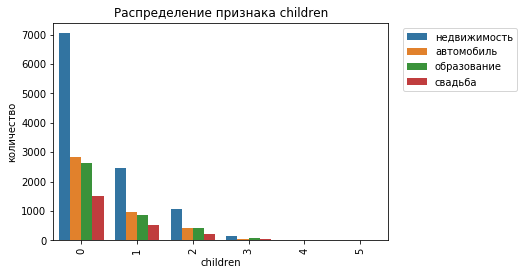

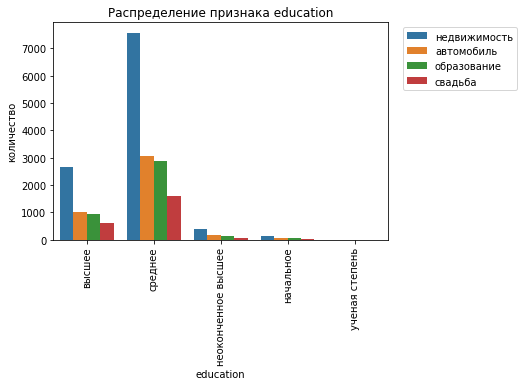

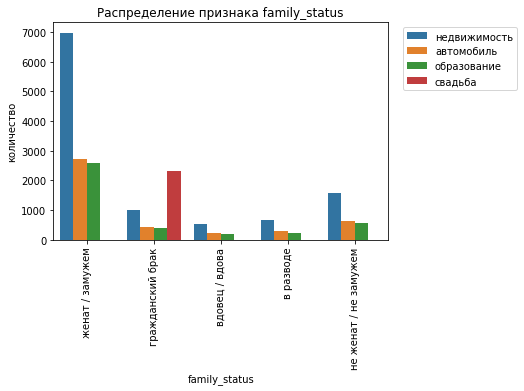

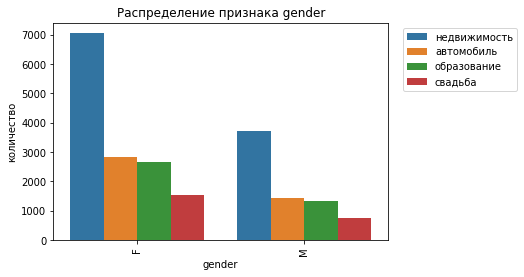

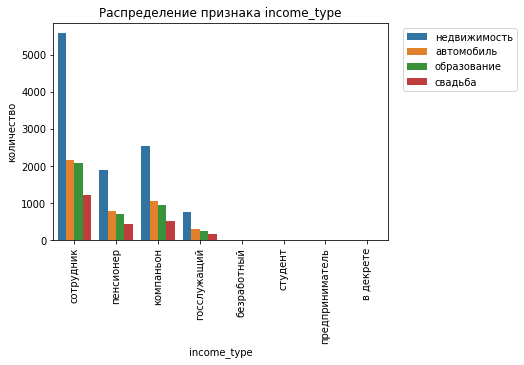

In [54]:
# Построим графики для дискретных величин
clients_discr_values = ['children', 'education', 'family_status', 'gender', 'income_type']
fig, ax = plt.subplots()
for column in clients_discr_values:
    plt.title("Распределение признака "+column)
    ax = sns.countplot(data=clients_info, x=column, hue='purpose')
    xax = ax.xaxis
    xlabels = xax.get_ticklabels()
    for label in xlabels:
        label.set_rotation(90)
    plt.xlabel(column)
    plt.ylabel("количество")
    plt.legend(bbox_to_anchor=(1.4, 1))
    plt.show()

Видим, что большая часть клиентов без детей берёт кредит на недвижимость, примерно в одинаковых долях они интересуются автомобилем и образованием, и немного меньше - свадьбой. Для клиентов с одним ребёнком тенденция аналогичная, только разрыв между "недвижимостью" и другими целями не так велик, а также берущих кредит на свадьбу ненамного меньше, чем на автомобиль или образование. Для клиентов с двумя детьми тенденции те же, а разрывы ещё меньше. И, наконец, клиенты с более чем 2 детьми имеют ещё меньшие разрывы в показателях (для них цели распределены более равномерно с некоторым перевесом указанных ранее).

По образованию наблюдается очень сильный разрыв в целях по количеству клиентов для среднего образования: очень значительная часть берёт кредит на недвижимость, и очень малая - на свадьбу. По остальным видам образования разрыв в цели "на недвижимость" не так высок, а "на свадьбу" близко к целям "на образование" или "на автомобиль".

Для всех категорий, кроме тех, кто находится в гражданском браке, сильно превалирует число клиентов с целью кредита на недвижимость. Находящиеся в гражданском браке беруть больше кредитов на свадьбу.

По полу нет особых различий между распределением клиентов по целям кредита.

По типу занятости очень сильный разрыв наблюдается в числе сотрудников, берущих кредит на недвижимость: их количество существенно отличается от других целей. Также для них цель "на свадьбу" намного непопулярней целей "на автомобиль" или "на образование". Для безработных, студентов, предпринимателей и людей в декрете сложно выделить тенденции, так как по ним данных недостаточно.

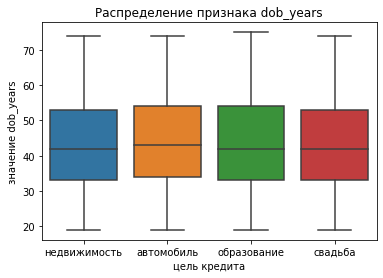

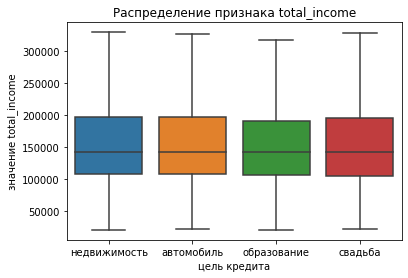

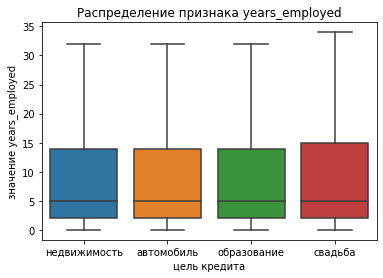

In [55]:
# Построим график для непрерывных величин без выбросов
clients_cont_values = ['dob_years', 'total_income', 'years_employed']
fig, ax = plt.subplots()
for column in clients_cont_values:
    plt.title("Распределение признака "+column)
    sns.boxplot(x='purpose', y=column, data=clients_info, showfliers=False)
    plt.xlabel('цель кредита')
    plt.ylabel('значение '+column)
    plt.show()

Каких-то значительных различий в распределении целей кредита по параметрам возраста, дохода и стажа не наблюдается (с учётом исключения выбросов).

### Вероятность получения кредита, исходя из уровня дохода <a id='step_2.2'></a>

Определим признак для категоризации данных. На наш взгляд, это не могут быть возрастные группы, поскольку среди клиентов нет детей (минимальный возраст составляет 19 лет, как было выявлено в процессе анализа соответствующего столбца). Использовать для категоризации пол, цель получения кредита и уровень образования не имеет смысла, поскольку напрямую они не оказывает влияния на возможности клиента по погашению кредита.

Данные могут быть категоризированны по нескольким признакам: наличие задолженности по возврату кредита, тип занятости, уровень дохода и семейное положение. На наш взгляд, в большей степени на возможность клиента вовремя погасить задолженность будет влиять его уровень дохода.

Для определения интервалов, в которые попадут категории, воспользуемся функцией `quantile()`.

In [56]:
print('Верхняя граница для первого интервала: {:.0f}'.format(np.quantile(clients_info['total_income'], 0.25)))
print('Верхняя граница для второго интервала: {:.0f}'.format(np.quantile(clients_info['total_income'], 0.5)))
print('Верхняя граница для третьего интервала: {:.0f}'.format(np.quantile(clients_info['total_income'], 0.75)))

Верхняя граница для первого интервала: 107646
Верхняя граница для второго интервала: 142594
Верхняя граница для третьего интервала: 195768


Создадим категории по вероятности возврата кредита, разбив промежуток на 4 равных отрезка, исходя из полученных значений квантилей:

- менее 107 646 ден.ед. - категория "низкая";
- от 107 646 до 142 594 ден.ед. - категория "средняя";
- от 142 594 до 195 768 ден.ед. - категория "высокая";
- более 195 768 ден.ед. - категория "очень высокая".

Запишем правила классификации клиентов как функции.

In [57]:
def income_group(income):
        if income <= np.quantile(clients_info['total_income'], 0.25):
            return 'низкая'
        if income <= np.quantile(clients_info['total_income'], 0.5):
            return 'средняя'
        if income <= np.quantile(clients_info['total_income'], 0.75):
            return 'высокая'
        else:
            return 'очень высокая'

Создадим «словарь»: каждому из клиентов запишем `id`, тип дохода `income_type`, величину дохода `income_total` и добавим новый столбец с вероятностью возврата кредита `probability`.

In [58]:
clients_info['id'] = range(len(clients_info))
clients_info['probability'] = clients_info['total_income'].apply(income_group)

Теперь рассмотрим, для скольки людей вероятность выдачи кредита является высокой, а для скольки - низкой.

In [59]:
clients_dict = clients_info[['id', 'income_type', 'total_income', 'probability']]
clients_dict.groupby('probability')['id'].count()

probability
высокая          5223
низкая           5338
очень высокая    5338
средняя          5452
Name: id, dtype: int64

Для 5 338 клиентов вероятность получения кредита очень высока, для 5 223 человек вероятность получения кредита высока, для 5 452 человек кредит вероятен, а для 5 338 - маловероятен. Однако, многое зависит от того, как выделять категории по доходам - при изменении верхних и нижних границ интервалов результат может быть иным.

Также любопытно изучить, насколько вероятность получения кредита разнится по другим факторам, имеющимся в данных. Аналогично предыдущему анализу, построим столбчатые диаграммы для дискретных переменных (число детей, образование, семейное положение, пол, тип занятости) и боксплоты для непрерывных переменных (возраст, доход, трудовой стаж).

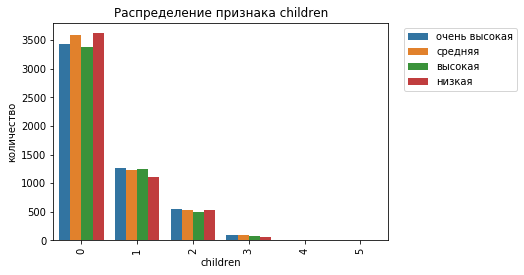

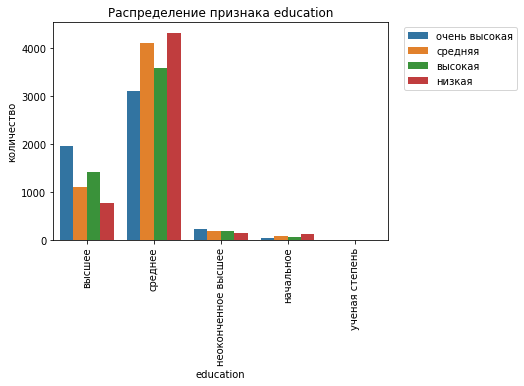

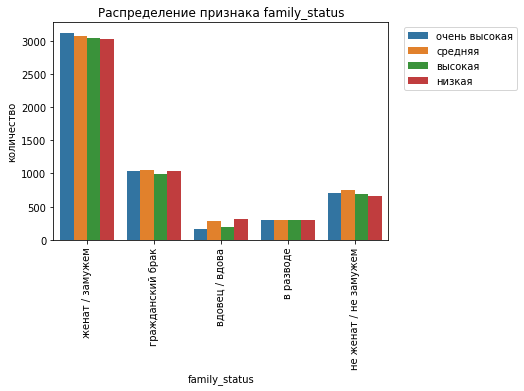

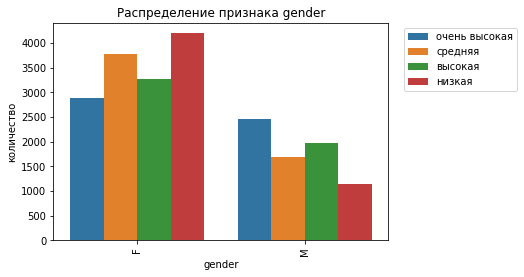

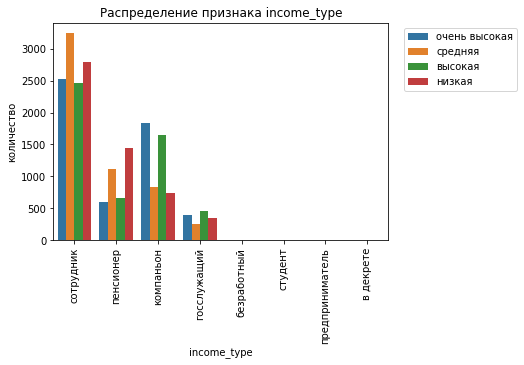

In [60]:
# Построим графики для дискретных величин
fig, ax = plt.subplots()
for column in clients_discr_values:
    plt.title("Распределение признака "+column)
    ax = sns.countplot(data=clients_info, x=column, hue='probability')
    xax = ax.xaxis
    xlabels = xax.get_ticklabels()
    for label in xlabels:
        label.set_rotation(90)
    plt.xlabel(column)
    plt.ylabel("количество")
    plt.legend(bbox_to_anchor=(1.4, 1))
    plt.show()

Для клиентов без детей вероятность выдачи кредита, в основном, средняя и низкая. Для клиентов с детьми (1 и более) вероятность выдачи распределена раномерно.

Для людей с высшим образованием преобладают клиенты с высокой и очень высокой вероятностью получения кредита, а для клиентов со средним или начальным образованием - со средней и очень низкой вероятностью. Для тех, у кого неоконченное высшее образование вероятности распределены примерно в равных долях.

По семейному положению не наблюдается существенных различий между категориями, кроме категории "вдовец / вдова": для них вероятность получения кредита в большей степени средняя или низкая.

Есть различия и по половому признаку: для женщин верятность получения кредита в большей степени средняя или низкая, а для мужчин - очень высокая или высокая. Это может быть связано не с гендерными различиями в подходе банка, а скорее, с гендерными различиями в доходах, которые сложились на рынке труда.

Для сотрудников и пенсионеров вероятность получения кредита, в большей степени, средняя или низкая. А для компаньонов и госслужащих - высокая и очень высокая. Но для госслужащих вероятности распределены более равномерно. По остальным категориям недостаточно данных для выявления закономерности.

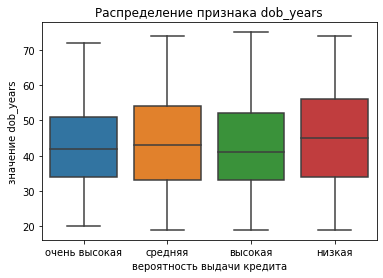

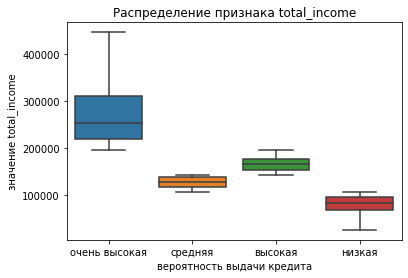

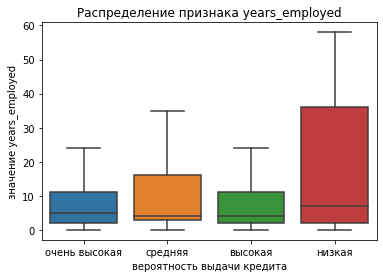

In [61]:
# Построим график для непрерывных величин без выбросов
fig, ax = plt.subplots()
for column in clients_cont_values:
    plt.title("Распределение признака "+column)
    sns.boxplot(x='probability', y=column, data=clients_info, showfliers=False)
    plt.xlabel('вероятность выдачи кредита')
    plt.ylabel('значение '+column)
    plt.show()

Для клиентов, характеризующихся очень высокой вероятностью получения кредита, характерен очень большой разброс в высоком уровне дохода, а также небольшой разброс в стаже.

Для клиентов, характеризующихся высокой вероятностью получения кредита, характерен малый разброс в уровне дохода, а также небольшой разброс в стаже.

Для клиентов, характеризующихся средней вероятностью получения кредита, характерен малый разброс в уровне дохода, чуть более высокий средний возраст (так как в эту категорию попали многие пенсионеры), а также средний разброс в стаже.

Для клиентов, характеризующихся низкой вероятностью получения кредита, характерен малый разброс в уровне дохода, чуть более высокий средний возраст (так как в эту категорию также попали многие пенсионеры), а также очень большой разброс в стаже.

### Зависимость между наличием детей и возвратом кредита в срок <a id='step_2.3'></a>

Для ответа на данный вопрос построим сводную таблицу, по строкам которой отразим число детей, по столбцам - наличие просроченной задолженности; а значения - это число клиентов.

In [62]:
child_debt_pivot = clients_info.pivot_table(index='children', columns='debt', values='id', aggfunc='count')
child_debt_pivot = child_debt_pivot.fillna(0).astype('int')
child_debt_pivot

debt,0,1
children,,
0,12962,1058
1,4397,442
2,1912,202
3,301,27
4,37,4
5,9,0


По абсолютным значениям сложно делать какие-то выводы, поскольку число обратившихся в банк клиентов в каждой категории, характеризующей число детей, также различно. В целом, мы видим, что число тех, кто долг не вернул примерно в 10 раз меньше, чем тех, кто его вернул.

Создадим столбец, показывающий процент людей, просрочивших кредит, и рассчитаем показатели для каждой из категорий.

In [63]:
child_debt_pivot['ratio'] = round((child_debt_pivot[1] / (child_debt_pivot[1] + child_debt_pivot[0]) * 100), 2)
child_debt_pivot.sort_values('ratio', ascending=False)

debt,0,1,ratio
children,,,
4,37,4,9.76
2,1912,202,9.56
1,4397,442,9.13
3,301,27,8.23
0,12962,1058,7.55
5,9,0,0.00


Количество клиентов, просрочивших кредит ранжируется от 0 до 9.76%. Четкой зависимости между наличием детей (а также их количеством) и возвратом кредита в срок нет. Только в случае, когда количество детей очень велико (5 человек), наблюдается 0% просроченной задолженности. 

Возможно, это связано с тем, что большое число детей люди заводят осознанно - имея высокие доходы для обеспечения большой семьи, и возврат долга все-таки зависит не от количества детей, а от доходов. Либо данных недостаточно для вывода, и в выборку попали только клиенты данной категории, которые не имеют негативного опыта по возврату кредитов.

### Зависимость между семейным положением и возвратом кредита в срок <a id='step_2.4'></a>

Для ответа на данный вопрос построим сводную таблицу, по строкам которой отразим семейное положение, по столбцам - наличие просроченной задолженности; а значения - это число клиентов.

In [64]:
family_debt_pivot = clients_info.pivot_table(index='family_status', columns='debt', values='id', aggfunc='count')
family_debt_pivot

debt,0,1
family_status,,
в разводе,1100,85
вдовец / вдова,892,62
гражданский брак,3743,386
женат / замужем,11362,927
не женат / не замужем,2521,273


Мы также не можем ответить на поставленный вопрос по абсолютным значениям. В целом, мы видим, что число тех, кто долг не вернул примерно в 10 раз меньше, чем тех, кто его вернул.

Создадим столбец, показывающий процент людей, просрочивших кредит, и рассчитаем показатели для каждой из категорий.

In [65]:
family_debt_pivot['ratio'] = round((family_debt_pivot[1] / (family_debt_pivot[1] + family_debt_pivot[0]) * 100), 2)
family_debt_pivot.sort_values('ratio', ascending=False)

debt,0,1,ratio
family_status,,,
не женат / не замужем,2521,273,9.77
гражданский брак,3743,386,9.35
женат / замужем,11362,927,7.54
в разводе,1100,85,7.17
вдовец / вдова,892,62,6.50


Наблюдается следующая зависимость между семейным положением и возвратом кредита в срок: наибольший процент невозврата (9.77%) характерен для неженатых/незамужних людей; для людей в гражданском браке он равен 9.35%; для женатых - 7.54%; клиентов в разводе - 7.17%; и для вдовцов/вдов составляет 6.5%. 

Возможно, это связано с психологическим фактором: люди, готовые к ответственности, живут в официальном браке - соответственно, они с ответственностью подходят и к погашению кредита. Те, кто живет один (не женат/не замужем) менее ответственны и в то же время могут "положиться только на себя", соответственно, позволяют себе не выплачивать долг по кредиту в срок.

### Зависимость между уровнем дохода и возвратом кредита в срок <a id='step_2.5'></a>

Для ответа на данный вопрос построим сводную таблицу, по строкам которой отразим уровень дохода, по столбцам - наличие просроченной задолженности; а значения - это число клиентов. Выше мы уже категоризировали данные по доходу в виде вероятности выдачи кредита (это равнозначные показатели: чем выше уровень дохода, тем выше вероятность выдачи кредита). Воспользуемся этими результатами.

In [66]:
income_debt_pivot = clients_info.pivot_table(index='probability', columns='debt', values='id', aggfunc='count')
income_debt_pivot = income_debt_pivot.fillna(0).astype('int')
income_debt_pivot

debt,0,1
probability,,
высокая,4778,445
низкая,4913,425
очень высокая,4956,382
средняя,4971,481


Создадим столбец, показывающий процент людей, просрочивших кредит, и рассчитаем показатели для каждой из категорий.

In [67]:
income_debt_pivot['ratio'] = round((income_debt_pivot[1] / (income_debt_pivot[1] + income_debt_pivot[0]) * 100), 2)
income_debt_pivot.sort_values('ratio', ascending=False)

debt,0,1,ratio
probability,,,
средняя,4971,481,8.82
высокая,4778,445,8.52
низкая,4913,425,7.96
очень высокая,4956,382,7.16


Между уровнем дохода и числом невозвращенных кредитов наблюдается следующая зависимость: когда уровень дохода слишком низок или слишком высок, около 7.16-7.96% клиентов не возвращает долг в срок; когда уровень дохода средний и высокий, доля тех, кто кредит не возвращает, выше и составляет 8,52-8,82%.

Процент невозврата для категорий со средним доходом (самый высокий процент) и с очень высоким доходом (самый низкий процент) вполне предсказуем. Странной выглядит доля невозврата для людей с высоким доходом и низким: для людей с низким доходом этот процент ниже, чем для людей с высоким. Таким образом, можем сделать вывод о том, что явной зависимости между уровнем дохода и возвратом кредита в срок нет.

### Зависимость между целями кредита и возвратом кредита в срок <a id='step_2.6'></a>

Для ответа на данный вопрос построим сводную таблицу, по строкам которой отразим цели получения кредита, по столбцам - наличие просроченной задолженности; а значения - это число клиентов.

In [68]:
purpose_debt_pivot = clients_info.pivot_table(index='purpose', columns='debt', values='id', aggfunc='count')
purpose_debt_pivot

debt,0,1
purpose,,
автомобиль,3884,400
недвижимость,9983,779
образование,3625,370
свадьба,2126,184


Создадим столбец, показывающий процент людей, просрочивших кредит, и рассчитаем показатели для каждой из категорий.

In [69]:
purpose_debt_pivot['ratio'] = round((purpose_debt_pivot[1] / (purpose_debt_pivot[1] + purpose_debt_pivot[0]) * 100), 2)
purpose_debt_pivot.sort_values('ratio', ascending=False)

debt,0,1,ratio
purpose,,,
автомобиль,3884,400,9.34
образование,3625,370,9.26
свадьба,2126,184,7.97
недвижимость,9983,779,7.24


Между целями кредита и возвратом его в срок наблюдается следующая зависимость: в большей степени возвращают кредит на недвижимость (7,24% невозврат) и свадьбу (7,97% невозврат); в меньшей степени - на автомобиль (9,34%) и образование (9,26%).

Возможно, это связано с возрастом и жизненным этапом клиентом - то есть психологической готовностью взять на себя ответственность и выполнить обязательства: автомобиль и образование приобретаются на более раннем жизненном этапе; свадьба и недвижимость - на более позднем. Таким образом, мы можем выявить зависимость между этими показателями.

### Вывод <a id='step_2.7'></a>

Нами были выделены леммы в значениях столбца с целью получения кредита. Сначала определены уникальные значения, которые были лемматизированы. Затем на их основе были выделены группы (категории) для подстановки в столбец. В результате мы получили 4 284 человека с целью кредита на автомобиль; 10 762 человека с целью кредита на недвижимость; 3 995 клиентов с целью образования; и 2 310 человек - на свадьбу.

При этом большая часть клиентов без детей берёт кредит на недвижимость, примерно в одинаковых долях они интересуются автомобилем и образованием, и немного меньше - свадьбой. Для клиентов с одним ребёнком тенденция аналогичная, только разрыв между "недвижимостью" и другими целями не так велик, а также берущих кредит на свадьбу ненамного меньше, чем на автомобиль или образование. Для клиентов с двумя детьми тенденции те же, а разрывы ещё меньше. И, наконец, клиенты с более чем 2 детьми имеют ещё меньшие разрывы в показателях (для них цели распределены более равномерно с некоторым перевесом указанных ранее). По образованию наблюдается очень сильный разрыв в целях по количеству клиентов для среднего образования: очень значительная часть берёт кредит на недвижимость, и очень малая - на свадьбу. По остальным видам образования разрыв в цели "на недвижимость" не так высок, а "на свадьбу" близко к целям "на образование" или "на автомобиль". Для всех категорий, кроме тех, кто находится в гражданском браке, сильно превалирует число клиентов с целью кредита на недвижимость. Находящиеся в гражданском браке беруть больше кредитов на свадьбу. По полу нет особых различий между распределением клиентов по целям кредита. По типу занятости очень сильный разрыв наблюдается в числе сотрудников, берущих кредит на недвижимость: их количество существенно отличается от других целей. Также для них цель "на свадьбу" намного непопулярней целей "на автомобиль" или "на образование". Для безработных, студентов, предпринимателей и людей в декрете сложно выделить тенденции, так как по ним данных недостаточно. Каких-то значительных различий в распределении целей кредита по параметрам возраста, дохода и стажа не наблюдается (с учётом исключения выбросов).

Также была проведена категоризация данных. Поскольку наиболее очевидным признаком, по которому мы можем судить о вероятности погашения задолженности клиентом, является его доход, он и был выбран в качестве критерия: чем выше доход, тем вероятнее выдача кредита клиенты (так как выше его платёжеспособность). Однако, следует отметить, что за неимением других данных, доход был разбит нами на 5 равных категорийных отрезков; что может повлиять на принятие неверных решений. Границы должны обсуждаться с заказчиком проекта (банком) и при необходимости корректироваться.

Для клиентов без детей вероятность выдачи кредита, в основном, средняя и низкая. Для клиентов с детьми (1 и более) вероятность выдачи распределена раномерно. Для людей с высшим образованием преобладают клиенты с высокой и очень высокой вероятностью получения кредита, а для клиентов со средним или начальным образованием - со средней и очень низкой вероятностью. Для тех, у кого неоконченное высшее образование вероятности распределены примерно в равных долях. По семейному положению не наблюдается существенных различий между категориями, кроме категории "вдовец / вдова": для них вероятность получения кредита в большей степени средняя или низкая. Есть различия и по половому признаку: для женщин верятность получения кредита в большей степени средняя или низкая, а для мужчин - очень высокая или высокая. Это может быть связано не с гендерными различиями в подходе банка, а скорее, с гендерными различиями в доходах, которые сложились на рынке труда. Для сотрудников и пенсионеров вероятность получения кредита, в большей степени, средняя или низкая. А для компаньонов и госслужащих - высокая и очень высокая. Но для госслужащих вероятности распределены более равномерно. По остальным категориям недостаточно данных для выявления закономерности.

Для клиентов, характеризующихся очень высокой вероятностью получения кредита, характерен очень большой разброс в высоком уровне дохода, а также небольшой разброс в стаже. Для клиентов, характеризующихся высокой вероятностью получения кредита, характерен малый разброс в уровне дохода, а также небольшой разброс в стаже. Для клиентов, характеризующихся средней вероятностью получения кредита, характерен малый разброс в уровне дохода, чуть более высокий средний возраст (так как в эту категорию попали многие пенсионеры), а также средний разброс в стаже. Для клиентов, характеризующихся низкой вероятностью получения кредита, характерен малый разброс в уровне дохода, чуть более высокий средний возраст (так как в эту категорию также попали многие пенсионеры), а также очень большой разброс в стаже.

Затем был проведён анализ факторов, которые могут оказывать влияние на возврат кредита. Количество клиентов, просрочивших кредит ранжируется от 0 до 9.76%. Четкой зависимости между наличием детей (а также их количеством) и возвратом кредита в срок нет. Только в случае, когда количество детей очень велико (5 человек), наблюдается 0% просроченной задолженности. Возможно, это связано с тем, что большое число детей люди заводят осознанно - имея высокие доходы для обеспечения большой семьи, и возврат долга все-таки зависит не от количества детей, а от доходов. Либо данных недостаточно для вывода, и в выборку попали только клиенты данной категории, которые не имеют негативного опыта по возврату кредитов.

Наблюдается следующая зависимость между семейным положением и возвратом кредита в срок: наибольший процент невозврата (9.77%) характерен для неженатых/незамужних людей; для людей в гражданском браке он равен 9.35%; для женатых - 7.54%; клиентов в разводе - 7.17%; и для вдовцов/вдов составляет 6.5%. Возможно, это связано с психологическим фактором: люди, готовые к ответственности, живут в официальном браке - соответственно, они с ответственностью подходят и к погашению кредита. Те, кто живет один (не женат/не замужем) менее ответственны и в то же время могут "положиться только на себя", соответственно, позволяют себе не выплачивать долг по кредиту в срок.

Между уровнем дохода и числом невозвращенных кредитов наблюдается следующая зависимость: когда уровень дохода слишком низок или слишком высок, около 7.16-7.96% клиентов не возвращает долг в срок; когда уровень дохода средний и высокий, доля тех, кто кредит не возвращает, выше и составляет 8,52-8,82%. Процент невозврата для категорий со средним доходом (самый высокий процент) и с очень высоким доходом (самый низкий процент) вполне предсказуем. Странной выглядит доля невозврата для людей с высоким доходом и низким: для людей с низким доходом этот процент ниже, чем для людей с высоким. Таким образом, можем сделать вывод о том, что явной зависимости между уровнем дохода и возвратом кредита в срок нет.

Между целями кредита и возвратом его в срок наблюдается следующая зависимость: в большей степени возвращают кредит на недвижимость (7,24% невозврат) и свадьбу (7,97% невозврат); в меньшей степени - на автомобиль (9,34%) и образование (9,26%). Возможно, это связано с возрастом и жизненным этапом клиентом - то есть психологической готовностью взять на себя ответственность и выполнить обязательства: автомобиль и образование приобретаются на более раннем жизненном этапе; свадьба и недвижимость - на более позднем. Таким образом, мы можем выявить зависимость между этими показателями.

### Общий вывод <a id='step_3'></a>

В исследовании **были проанализированы** данные о платёжеспособности 21 525 клиентов, которые включают в себя такие характеристики как количество детей в семье, общий трудовой стаж, возраст клиента, уровень образования, семейное положение, пол клиента, тип занятости, наличие/отсутствие задолженности по возврату кредитов в прошлом, ежемесячный доход, цель получения кредита.

**Цели получения кредита** были разделены на четыре основные категории: недвижимость, образование, автомобиль и свадьба - исходя из целей, указанных клиентами. Мы получили 4 284 человека с целью кредита на автомобиль; 10 762 человека с целью кредита на недвижимость; 3 995 клиентов с целью образования; и 2 310 человек - на свадьбу. При этом **явных зависимостей между целями кредита и другими факторами не наблюдается**. 

Также **была проведена категоризация данных**. Поскольку наиболее очевидным признаком, по которому мы можем судить о вероятности погашения задолженности клиентом, является его **доход**, он и **был выбран в качестве критерия**: чем выше доход, тем вероятнее выдача кредита клиенты (так как выше его платёжеспособность). Однако, следует отметить, что за неимением других данных, доход был разбит нами на 5 равных категорийных отрезков; что может повлиять на принятие неверных решений. Границы должны обсуждаться с заказчиком проекта (банком) и при необходимости корректироваться.

**По категориям дохода** (вероятности получения кредита) были выявлены **следующие закономерности** по другим факторам. Для клиентов без детей вероятность выдачи кредита, в основном, средняя и низкая. Для клиентов с детьми (1 и более) вероятность выдачи распределена раномерно. Для людей с высшим образованием преобладают клиенты с высокой и очень высокой вероятностью получения кредита, а для клиентов со средним или начальным образованием - со средней и очень низкой вероятностью. По семейному положению не наблюдается существенных различий между категориями, кроме категории "вдовец / вдова": для них вероятность получения кредита в большей степени средняя или низкая. Есть различия и по половому признаку: для женщин верятность получения кредита в большей степени средняя или низкая, а для мужчин - очень высокая или высокая. Это может быть связано не с гендерными различиями в подходе банка, а скорее, с гендерными различиями в доходах, которые сложились на рынке труда. Для сотрудников и пенсионеров вероятность получения кредита, в большей степени, средняя или низкая. А для компаньонов и госслужащих - высокая и очень высокая. Но для госслужащих вероятности распределены более равномерно. По остальным категориям недостаточно данных для выявления закономерности.

Затем был проведён **анализ факторов, которые могут оказывать влияние на возврат кредита**. Клиенты с практически любым количеством детей (или при их отсутствии) в 9 случаях из 100 возвращают кредит. Однако многодетные семьи (с 5 детьми) делают это в 100 случаях из 100 (хотя выборки может быть недостаточно для такого вывода). Тем не менее, фактором возможности возврата долга может служить не количество детей, а наличие соответствующих доходов, а также готовность к ответственности. То же самое характерно и для семейного положения: живущие в гражданском браке или незамужние возвращают кредит реже, чем замужние, вдовцы и разведенные. Это также косвенно может быть связано с готовностью к ответственности или возрастом клиента. Между уровнем дохода и возвратом кредита не наблюдается прямой зависимости имеют просрочку кредита как люди с высоким доходом, так и с низким (процент в обоих категориях очень близок). Между целями кредита и его возвратом в срок наблюдается прямая зависимость: цели, связаные с более высокими затратами и более поздним жизненным этапом (недвижимость, свадьба), характеризуются более высокими показателями по возврату долга, чем цели кредита на образование и автомобиль.

Так, в процессе исследования были построены следующие **рабочие гипотезы**:
* между наличием детей и возвратом кредита в срок есть зависимость;
* между семейным положением и возвратом кредита в срок есть зависимость;
* между уровнем дохода и возвратом кредита в срок есть зависимость;
* разные цели кредита влияют на его возврат в срок.

В результате **первая гипотеза не подтверждена, вторая гипотеза подтверждена, третья гипотеза не подтверждена, и четвертая гипотеза подтверждена**.

### Рекомендации <a id='step_4'></a>

Исследование позволило разработать следующие **рекомендации по построению модели кредитного скоринга**.

1) В системе не следует учитывать количество детей. 

2) Следует учитывать семейное положение клиента: наибольший процент невозврата характерен для неженатых/незамужних людей и для людей в гражданском браке; для женатых/замужних и в разводе процент невозврата ниже; а для вдовцов/вдов он самый низкий.

3) Уровень дохода не следует учитывать как основной фактор в модели.

4) Одним из существенных факторов возврата кредита следует установить цель получения кредита.